## Часть 1. Добываем данные по карточкам, записываем в pg, убираем дубли

In [3]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import math
import time
import mcfg #в файле лежат функции pg1,pg2 для подключения к postgresql
import warnings
warnings.filterwarnings('ignore')

In [2]:
# articles = 6657 #кол-во объявлений (ориентировочно, меняется ежеминутно)
# num_on_page = 28 #отображается на одной странице
# pages = math.ceil(articles/num_on_page) #страниц распарсить

def insert_to_pg(content,reg):
    '''функция получает на вход текст страницы, забирает оттуда объявления и вносит в 3 колонки:
    айди объявления
    ссылка на объявление
    полный текст html элемента, который можно допарсить
    '''
    #CREATE TABLE team18.ads_list ( add_id text, add_link text, add_text text);
    #ALTER TABLE team18.ads_list ADD COLUMN district text;

    soup = BeautifulSoup(content, "html.parser")
    ads = soup.findAll('article') #вытаскиваем по тегу все карточки
    for ad in ads:
        ad_link = ad.find('a', href=True)['href']
        full_ad = str(ad)
        ad_id = ad_link.split(r'/')[-2]


        sql = f"""insert into team18.ads_list (add_id,add_link,add_text,district) 
        VALUES ('{ad_id}',
        '{ad_link}',
        '{full_ad.replace("'",'"')}',
        '{reg}')

        """
        conn = mcfg.pg2()
        cur = conn.cursor()
        cur.execute(sql)
        conn.commit()
        conn.close()

district_dict = {'district%5B0%5D=1&':'СЗАО 569', #слоаврь фильтров с примерным кол-вом объявлений
'district%5B10%5D=325&':'Новомосковский 697',
'district%5B11%5D=326&':'Троицкий 47',
'district%5B1%5D=4&':'ЦАО 578',
'district%5B2%5D=5&':'САО 682',
'district%5B3%5D=6&':'СВАО 674',
'district%5B4%5D=7&':'ВАО 604',
'district%5B5%5D=8&':'ЮВАО 739',
'district%5B6%5D=9&':'ЮАО 793',
'district%5B7%5D=10&':'ЮЗАО 516',
'district%5B8%5D=11&':'ЗАО 776',
'district%5B9%5D=151&':'Зеленоградский 79'}
for district in district_dict:
    for page in range(1,math.ceil(int(district_dict[district].split(' ')[1])/28)+1):  
        link = f'https://www.cian.ru/cat.php?deal_type=rent&{district}engine_version=2&offer_type=flat&p={page}&region=1&room1=1&type=4'
        driver = webdriver.Chrome() 
        driver.get(link)
        time.sleep(10)
        content = driver.page_source
        driver.quit()
        insert_to_pg(content,district_dict[district].split(' ')[0])

        print(f"{district_dict[district].split(' ')[0]} {page}/{math.ceil(int(district_dict[district].split(' ')[1])/28)} done                                      ",end='\r')

In [4]:
#Проверяем датасет
#Есть примеры, когда одно объявение относится к нескольким районам

df = pd.read_sql('''
with cte as (
	select
	add_id,
	count(distinct district) cnt
	from
	team18.ads_list al 
	group by 1)
,cte2 as (
	select * from cte where cnt >1)
select add_id,add_link,district,count(*) over(partition by add_id) cnt from team18.ads_list al 
where add_id in (select add_id from cte2)
order by cnt desc,add_id
                 ''',con=mcfg.pg2())
df

,add_id,add_link,district,cnt
0,311944763,https://www.cian.ru/rent/flat/311944763/,САО,6
1,311944763,https://www.cian.ru/rent/flat/311944763/,ЦАО,6
2,311944763,https://www.cian.ru/rent/flat/311944763/,ЮАО,6
3,311944763,https://www.cian.ru/rent/flat/311944763/,ЗАО,6
4,311944763,https://www.cian.ru/rent/flat/311944763/,СВАО,6
...,...,...,...,...
64,312534705,https://www.cian.ru/rent/flat/312534705/,Троицкий,2
65,312543343,https://www.cian.ru/rent/flat/312543343/,Новомосковский,2
66,312543343,https://www.cian.ru/rent/flat/312543343/,Троицкий,2
67,312617086,https://www.cian.ru/rent/flat/312617086/,ЦАО,2


In [5]:
#С учетом предыдущих дублей, есть дубли, которые возникли в следствие обновления количества объявлений 
#на сайте, что влияло на отображение на конкретной странице конкретных объявлений
#Таким образом из исходной таблицы, после исключения дублей, остается 6043 карточки из 6877
df = pd.read_sql('''
select
	count(add_id) all_ads,
	count(distinct add_id) unique_ads
from
	team18.ads_list
                 ''',con=mcfg.pg2())
df

,all_ads,unique_ads
0,6877,6043


In [6]:
#Готовим датасет pkl без дублей
df = pd.read_sql('''
with base as (
	select
	*,
	row_number() over(partition by add_id order by add_id) rn
	from
	team18.ads_list)
select add_id,add_link,add_text,district from base where rn = 1
                 ''',con=mcfg.pg2())
df.to_pickle('ads_list.pkl')

## Часть 2. Парсим карточки и записываем в pg

In [23]:
import pandas as pd
from bs4 import BeautifulSoup
import mcfg
import warnings
warnings.filterwarnings('ignore')

df = pd.read_pickle('ads_list.pkl')

# soup = BeautifulSoup(content, "html.parser")
# ads = soup.findAll('article')

add_id_list = []
add_link_list = []
district_list = []
ad_date_list = []
ad_title_list = []  
metro_list = []
do_metro_list = []
address_list = []
price_list = []
description_list = []
m_sqarea_list = []
floor_flat_list = []
floor_max_list = []

for index,row in df.iterrows():
    
    add_id = row['add_id']
    text = row['add_text']
    add_link = row['add_link']
    district = row['district']

    soup = BeautifulSoup(text, "html.parser").find('div',class_='_93444fe79c--content--lXy9G')
    ad_date = soup.find('div',class_='_93444fe79c--absolute--yut0v').text
    ad_title = soup.find('div',class_='_93444fe79c--row--kEHOK').text
    try:
        metro = soup.find('a',class_='_93444fe79c--link--BwwJO').text
    except:
        metro = 'tbd'
    try:
        do_metro = soup.find('div',class_='_93444fe79c--remoteness--q8IXp').text
    except:
        do_metro = 'tbd'
    address = soup.find('div',class_='_93444fe79c--labels--L8WyJ').text
    price = soup.find('div',class_='_93444fe79c--container--aWzpE').text.replace('₽/мес.','').replace(' ','')
    try: 
        description = soup.find('p',class_='_93444fe79c--color_text-primary-default--vSRPB').text
    except:
        description = 'empty'

    m_sqarea = ad_title.split('м²')[-2:][0].strip().split(' ')[-1]
    floor_flat = ad_title.split('м²')[-1].replace(',','').strip().split(' ')[0].split('/')[0]
    floor_max = ad_title.split('м²')[-1].replace(',','').strip().split(' ')[0].split('/')[1]

    add_id_list.append(add_id)
    add_link_list.append(add_link)
    district_list.append(district)
    ad_date_list.append(ad_date)
    ad_title_list.append(ad_title)
    metro_list.append(metro)
    do_metro_list.append(do_metro)
    address_list.append(address)
    price_list.append(price)
    description_list.append(description)
    m_sqarea_list.append(float(m_sqarea.replace(',','.')))
    floor_flat_list.append(float(floor_flat))
    floor_max_list.append(float(floor_max))

df_itog = pd.DataFrame({'add_id':add_id_list,
                    'add_link':add_link_list,
                    'district':district_list,
                    'ad_date':ad_date_list,
                    'ad_title':ad_title_list,
                    'metro':metro_list,
                    'do_metro':do_metro_list,
                    'address':address_list,
                    'price':price_list,
                    'description':description_list,
                    'm_sqarea':m_sqarea_list,
                    'floor_flat':floor_flat_list,
                    'floor_max':floor_max_list})
df_itog.to_sql(name='ads_cards_detailed',schema='team18',con=mcfg.pg1(),if_exists='replace',index=False)

43

## Часть 3. Геокодер

In [57]:
import pandas as pd
import mcfg
import json
import warnings
import requests
warnings.filterwarnings('ignore')

df = pd.read_sql('''
select * from team18.ads_cards_detailed
                 ''',con=mcfg.pg2())


In [58]:
address_list = []
geopoint_list = []
id_list = []

for index,row in df.iterrows():
    response = requests.get(f"https://geocode-maps.yandex.ru/1.x/?apikey={mcfg.yandex_geocoder}&geocode={row['address']}&format=json".replace(' ','+'))
    geopoint = json.loads(response.text)['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']

    address_list.append(row['address'])
    geopoint_list.append(geopoint)
    id_list.append(row['add_id'])


    print(index,end='\r')

df_geocode = pd.DataFrame({'address':address_list,'geopoint':geopoint_list,'add_id':id_list})

In [59]:
df_geocode['lat'] = df_geocode['geopoint'].apply(lambda x: float(x.split(' ')[1]))
df_geocode['lon'] = df_geocode['geopoint'].apply(lambda x: float(x.split(' ')[0]))
df_geocode.to_pickle('df_geocode.pkl')
df_geocode.to_sql(name='geocode_table',schema='team18',con=mcfg.pg1(),if_exists='replace',index=False)

43

## 4.1 Забираем полигоны Москвы из OSM

<AxesSubplot:>

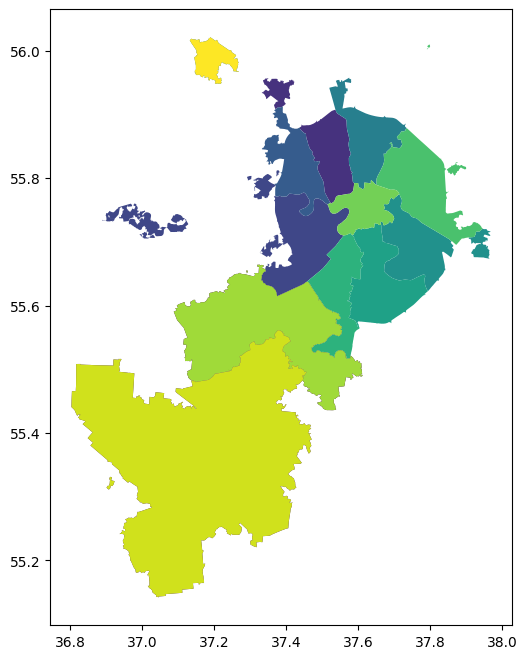

In [10]:
import pandas as pd
import osmnx as ox
import warnings 
from IPython.display import clear_output

tst = ox.geometries_from_place('Moscow, Russia', 
                               tags={'admin_level': '5'}) #забираем полигоны по Москве на уровне 5 (административные округа)
tst2 = ox.geometries_from_place('Troitsky Administrative Okrug', 
                               tags={'admin_level': '5'}) #забираем Троицкий округ
tst3 = ox.geometries_from_place('Zelenograd', 
                               tags={'admin_level': '5'}) #забираем Зеленоград

df = pd.concat([tst.reset_index()
               ,tst2.reset_index()
               ,tst3.reset_index()]) #избавляемся от мультииндекса
df = df[df['element_type']=='relation'][['geometry','osmid','name']] #оставляем только полигоны и убираем лишние поля

clear_output()
df.plot(cmap = "viridis",figsize=(20,8)) #проверям, что все выгрузилось верно

## 4.2 Упрощаем полигоны для отображения в BI и пеерводим wkt в нужный формат

In [11]:
from shapely import wkt
import mcfg

df['wkt_simplified'] = df['geometry'].simplify(tolerance=0.0001,
                                               preserve_topology=True) #упрощаем полигоны, сохраняя общую границу для них

for column in df: #переводим в текстовый формат
    df[column] = df[column].astype(str)

def qlik_format(x):
    '''функция для перевода из wkt в формат для BI'''
    if 'MULTIPOLYGON' in x:
        return x.replace('MULTIPOLYGON','')\
        .strip()\
        .replace(', ','],[')\
        .replace('(','[')\
        .replace(')',']')\
        .replace(']]],[[[',']],[[')\
        .replace(' ',',')
    elif 'POLYGON' in x:
        return '[' + x.replace('POLYGON','')\
        .strip()\
        .replace(', ','],[')\
        .replace('(','[')\
        .replace(')',']')\
        .replace(']]],[[[',']],[[')\
        .replace(' ',',') + ']'
    return x

df['wkt_simplified_bi'] = df['wkt_simplified'].apply(qlik_format) #добавялем колонку с форматом полигона для BI

#количество символов в строке сокращается в разы, что дает существенный прирост в производительности дашборда
# df['len1'] = df['geometry'].apply(len) 
# df['len2'] = df['wkt_simplified'].apply(len)

#меняем местами широту и долготу для формата BI
df['wkt_simplified_bi'] = df['wkt_simplified_bi'].apply(lambda x: str([[lvl2[::-1] for lvl2 in lvl1] for lvl1 in eval(x)])) # инвертируем для bi
clear_output()
df = df.drop_duplicates()

df.to_sql(name='msc_polygons',
          schema='team18',
          con=mcfg.pg1(),
          index=False,
          if_exists='replace')

12

## 4.3 Сопоставляем гео полигоны с точками объявлений (сверка с уже имеющимися данными)

In [5]:
import pandas as pd
import mcfg 
import warnings
warnings.filterwarnings('ignore')
# sudo apt install postgis
# CREATE EXTENSION postgis;

#Запрос сопоставляет по полигонам точки, формируется справочник, где каждому айди объявления соответствует один полигон (название), далее сверим с уже имеющимися данными


sql = '''drop table if exists team18.msc_dim;
create table team18.msc_dim as 
--
with poly as (
	select
	osmid,
	st_geomfromtext(geometry) polygon_geom --преобразуем в гео формат
	from
	team18.msc_polygons)
--
,points as (
	select
	st_point(lon,lat) as point, --преобразуем в гео формат
	add_id
	from
	team18.geocode_table)
--
,duplicates as (
    select 
    osmid,
    add_id,
    row_number() over(partition by add_id order by add_id) rn
    from points,poly 
    where st_intersects(point,polygon_geom)) --произведение множеств при условии пересечения точек с полигоном
select 
osmid,
add_id
from duplicates
where rn = 1'''

#2 точки потерялись, так как фактически не входят в границы полигонов

# select * from team18.ads_cards_detailed acd 
# where acd.add_id not in (select add_id from team18.msc_dim )

# Адерса этих точек:
# Москва, СЗАО, р-н Митино, м. Митино, Северо-Западный ао, улица Парковая, 33
# Москва, САО, р-н Молжаниновский, м. Химки, Ленинградское шоссе, 228к5



#Проверяем фактический район по координатам и исходные данные из циана
sql='''with al as (
select case
when district = 'Зеленоградский' then 	'Зеленоградский административный округ'
when district = 'ЮЗАО'then	'Юго-Западный административный округ'
when district = 'СЗАО'then	'Северо-Западный административный округ'
when district = 'Новомосковский'	then'Новомосковский административный округ'
when district = 'ЦАО'then	'Центральный административный округ'
when district = 'САО'	then'Северный административный округ'
when district = 'ВАО'then	'Восточный административный округ'
when district = 'СВАО'then	'Северо-Восточный административный округ'
when district = 'ЮВАО'then	'Юго-Восточный административный округ'
when district = 'ЮАО'then	'Южный административный округ'
when district = 'ЗАО'then	'Западный административный округ' end district, add_id,address from team18.ads_cards_detailed)
--
select al.district,address,ms.name from al
left join team18.msc_dim using(add_id)
left join team18.msc_polygons ms using(osmid)
where al.district!=name'''

# В результате мы видим 110 различий (бОльшая часть из них - связана с Троицким, Новомосковским округами)
# После фактической проверки можно сказать, что данные на основе полигонов точнее, чем на циане, поэтому для деления по районам лучше использовать их
df = pd.read_sql(sql,con=mcfg.pg2())
df.groupby(['district','name'],as_index=False).count()

,district,name,address
0,Восточный административный округ,Центральный административный округ,1
1,Западный административный округ,Новомосковский административный округ,2
2,Новомосковский административный округ,Западный административный округ,24
3,Новомосковский административный округ,Троицкий административный округ,46
4,Новомосковский административный округ,Юго-Западный административный округ,1
5,Северный административный округ,Западный административный округ,1
6,Северный административный округ,Северо-Западный административный округ,1
7,Северо-Восточный административный округ,Восточный административный округ,1
8,Северо-Западный административный округ,Западный административный округ,2
9,Северо-Западный административный округ,Северный административный округ,2
